In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edrixs

%matplotlib widget

In [2]:
nd = 8
norb_d = 10
norb_bath = 10
nbath = 1
v_noccu  = nd + nbath*norb_d
shell_name = ('d', 'p') # valence and core shells for XAS calculation

info  = edrixs.utils.get_atom_data('Ni', '3d', nd, edge='L3')
scale_dd = 0.85
F2_dd = info['slater_i'][1][1] * scale_dd
F4_dd = info['slater_i'][2][1] * scale_dd
U_dd = 7.3
F0_dd = U_dd + edrixs.get_F0('d', F2_dd, F4_dd)

scale_dp = 0.85
F2_dp = info['slater_n'][4][1] * scale_dp
G1_dp = info['slater_n'][5][1] * scale_dp
G3_dp = info['slater_n'][6][1] * scale_dp
U_dp = 8.5
F0_dp = U_dp + edrixs.get_F0('dp', G1_dp, G3_dp)
F0_pp, F2_pp = 0., 0.

slater = [[F0_dd, F2_dd, F4_dd,
           0, 0, 0, 0, 0, 0],
          [F0_dd, F2_dd, F4_dd,
           F0_dp, F2_dp, G1_dp, G3_dp,
           F0_pp, F2_pp]]

print(slater)

[[7.835149206349206, 10.3989, 6.4582999999999995, 0, 0, 0, 0, 0, 0], [7.835149206349206, 10.3989, 6.4582999999999995, 8.947816428571429, 6.56285, 4.91895, 2.79735, 0.0, 0.0]]


In [3]:
# crystal field and charge transfer
ten_dq = 0.56
ten_dq_bath = 1.44
Veg = 2.06
Vt2g = 1.21
Delta = 4.7

ext_B = np.array([0.12, 0.24, 0.12])/np.sqrt(6)/2
on_which = 'spin'

zeta_d = 0.081
c_soc = 11.51

om_shift = 857.6

thin = np.deg2rad(20)
thout = np.deg2rad(146) - thin
phi = 0.0
temperature = 13

pol_type_xas = [('linear', 0)]
pol_type_rixs = [('linear', 0, 'linear', 0),
                 ('linear', 0, 'linear', np.pi/2)]

In [4]:
E_d, E_L = edrixs.CT_imp_bath(U_dd, Delta, nd)
E_dc, E_Lc, E_p = edrixs.CT_imp_bath_core_hole(U_dd, U_dp, Delta, nd)


trans_c2n = edrixs.tmat_c2r('d',True)
CF = np.zeros((norb_d, norb_d), dtype=complex)
diagonal_indices = np.arange(norb_d)

orbital_energies = np.array([e for orbital_energy in
                             [+0.6 * ten_dq, # dz2
                              -0.4 * ten_dq, # dzx
                              -0.4 * ten_dq, # dzy
                              +0.6 * ten_dq, # dx2-y2
                              -0.4 * ten_dq] # dxy)
                             for e in [orbital_energy]*2])

CF[diagonal_indices, diagonal_indices] = orbital_energies
soc = edrixs.cb_op(edrixs.atom_hsoc('d', zeta_d), edrixs.tmat_c2r('d', True))
E_d_mat = E_d*np.eye(norb_d)
E_dc_mat = E_dc*np.eye(norb_d)
imp_mat = CF + soc + E_d_mat
imp_mat_n = CF + soc + E_dc_mat

bath_level = np.full((nbath, norb_d), E_L, dtype=complex)
bath_level[0, :2] += ten_dq_bath*.6  # 3z2-r2
bath_level[0, 2:6] -= ten_dq_bath*.4  # zx/yz
bath_level[0, 6:8] += ten_dq_bath*.6  # x2-y2
bath_level[0, 8:] -= ten_dq_bath*.4  # xy
bath_level_n = np.full((nbath, norb_d), E_Lc, dtype=complex)
bath_level_n[0, :2] += ten_dq_bath*.6  # 3z2-r2
bath_level_n[0, 2:6] -= ten_dq_bath*.4  # zx/yz
bath_level_n[0, 6:8] += ten_dq_bath*.6  # x2-y2
bath_level_n[0, 8:] -= ten_dq_bath*.4  # xy

hyb = np.zeros((nbath, norb_d), dtype=complex)
hyb[0, :2] = Veg  # 3z2-r2
hyb[0, 2:6] = Vt2g  # zx/yz
hyb[0, 6:8] = Veg  # x2-y2
hyb[0, 8:] = Vt2g  # xy

om_shift = 857.6
c_level = -om_shift - 5*E_p
ominc_xas = om_shift + np.linspace(-15, 25, 3000)
eloss = np.linspace(-0.3, 9, 3000)
gamma_c = 0.2
gamma_f = 0.01

In [5]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

eval_i, denmat, noccu_gs = edrixs.ed_siam_fort(
        comm, shell_name, nbath, siam_type=0, imp_mat=imp_mat, imp_mat_n=imp_mat_n,
        bath_level=bath_level, bath_level_n=bath_level_n, hyb=hyb, c_level=c_level,
        c_soc=c_soc, slater=slater, ext_B=ext_B,
        on_which=on_which, trans_c2n=trans_c2n, v_noccu=v_noccu, do_ed=1,
        ed_solver=2, neval=50, nvector=3, ncv=100, idump=True)


edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,  Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          7.8351492063        7.8351492063
     F2_vv :         10.3989000000       10.3989000000
     F4_vv :          6.4583000000        6.4583000000
     F0_vc :          0.0000000000        8.9478164286
     F2_vc :          0.0000000000        6.5628500000
     G1_vc :          0.0000000000        4.9189500000
     G3_vc :          0.0000000000        2.7973500000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

edrixs >>> do_ed=1, perform ED at noccu:  18


In [6]:
impurity_occupation = np.sum(denmat[0].diagonal()[0:norb_d]).real
bath_occupation = np.sum(denmat[0].diagonal()[norb_d:]).real
print('Impurity occupation = {:.6f}\n'.format(impurity_occupation))
print('Bath occupation = {:.6f}\n'.format(bath_occupation))

Impurity occupation = 8.178955

Bath occupation = 9.821045



In [7]:
xas, xas_poles = edrixs.xas_siam_fort(
        comm, shell_name, nbath, ominc_xas, gamma_c=gamma_c, v_noccu=v_noccu, thin=thin,
        phi=phi, num_gs=3, pol_type=pol_type_xas, temperature=temperature)

edrixs >>> Running XAS ...
edrixs >>> Loop over for polarization:  0 linear


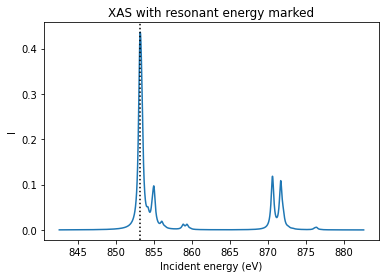

In [8]:
fig, ax = plt.subplots()

ax.plot(ominc_xas, xas.sum(-1))
ax.set_xlabel('Incident energy (eV)')
ax.set_ylabel('I')
ax.set_title('XAS with resonant energy marked')

resonance = ominc_xas[np.argmax(xas.sum(-1))]
ax.axvline(x=resonance, linestyle=':', color='k')


In [9]:
rixs_pols, rixs_poles = edrixs.rixs_siam_fort(comm, shell_name, nbath, [resonance], eloss, gamma_c=gamma_c,
                                       gamma_f=gamma_f, v_noccu=v_noccu, thin=thin, thout=thout, phi=phi,
                                       pol_type=pol_type_rixs, num_gs=3, temperature=temperature)
rixs = rixs_pols[0].sum(-1)

edrixs >>> Running RIXS ...

edrixs >>> Calculate RIXS for incident energy:  853.2435478492831
edrixs >>> Polarization:  0

edrixs >>> Calculate RIXS for incident energy:  853.2435478492831
edrixs >>> Polarization:  1


Text(0, 0.5, 'I')

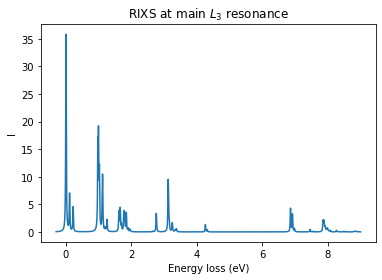

In [10]:
fig, ax = plt.subplots()

ax.plot(eloss, rixs)

ax.set_title('RIXS at main $L_3$ resonance')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')

(-0.2, 2.2)

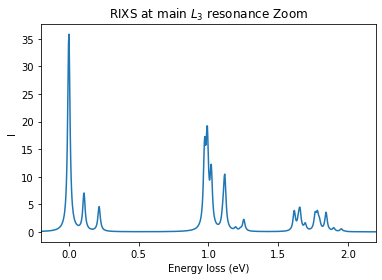

In [11]:
fig, ax = plt.subplots()

ax.plot(eloss, rixs)

ax.set_title('RIXS at main $L_3$ resonance Zoom')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')
ax.set_xlim(-.2, 2.2)